_This article was updated on **Tuesday, 1 November 2022**._

![](../images/2_bear_classifier_model/thumbnail.jpg){fig-alt="A bear waving hello."}

## Introduction

This is my first attempt at creating an AI model: an image classifier. This
classifier can tell whether a grizzly bear, black bear, or teddy bear is in
an image.

[//]: # (TODO: Link to new web app.)
You can visit the classifier [here](https://forbo7.github.io/web_apps/apps/bear_detector.html) to test it out for yourself!

## Load libraries

In [1]:
# No need to fret! fastai is specifically designed to be used with import *.
from fastbook import *
from fastai.vision.all import *

## Download image files

Specify the bear images we wish to download.

In [2]:
bear_types = ('grizzly', 'black', 'teddy',)
path = Path('bears')

Download 200 of each bear (`search_images_ddg` defaults to 200 URLs) and assign them to a specific directory.

In [3]:
if not path.exists():
    path.mkdir()
    for bear_type in bear_types:
        destination = (path / bear_type)
        destination.mkdir(exist_ok=True)
        urls = search_images_ddg(f"{bear_type} bear")
        download_iamges(destination, urls=urls)

Check if our folder has the image files.

In [4]:
fns = get_image_files(path)
fns

(#802) [Path('bears/grizzly/00000238.jpg'),Path('bears/grizzly/00000047.jpg'),Path('bears/grizzly/00000199.jpg'),Path('bears/grizzly/00000237.jpg'),Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000000.png'),Path('bears/grizzly/00000235.jpg'),Path('bears/grizzly/00000159.jpg'),Path('bears/grizzly/00000268.jpg'),Path('bears/grizzly/00000266.jpg')...]

Check for corrupt images.

In [5]:
corrupt_images = verify_images(fns)
corrupt_images

(#0) []

Remove corrupt images.

In [6]:
corrupt_images.map(pathlib.Path.unlink)

(#0) []

## Load image files

The DataBlock API for creates the necessary `DataLoaders` for us.

In [7]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

The `blocks` parameter allows us to specify the independent and dependent variables.

The `get_items` parameter tells fastai how to obtain our data. We use the `get_image_files` function to obtain our images.

The `splitter` parameter allows us to tell fastai how to split our data into training and validation sets. Since our data is one big set, we use the `RandomSplitter` class and tell it to use 20% of our data as the validation set. We specify a seed so the same split occurs each time.

The `get_y` parameter obtains our labels. The `parent_label` function simply gets the name of the folder a file is in. Since we have organized our bear images into different folders, this will nicely handle our target labels.

The `item_tfms` parameter allows us to specify a transform to apply to our data. Since we want all our images to be of the same size, we use the `Resize()` class.

We now have a DataBlock object from which can load the data.

In [8]:
dataloaders = bears.dataloaders(path)

Let us view a few images in the validation set.

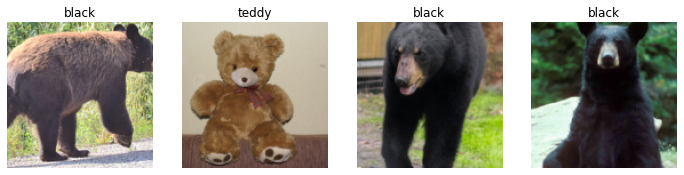

In [9]:
dataloaders.valid.show_batch(max_n=4, nrows=1)

## Data Augmentation

Data augmentation refers to creating random variations to our input data.
This produces new data points based on the existing data points. This allows
each data point to look different, without changing their meaning.

Typical examples of image augmentation include rotation, flipping,
perspective warping, brightness changing, and contrast changing.

### Cropping

The validation set images shown above are cropped. We achieved this by
specifying the `Resize` argument when defining the `DataBlock`. `Resize`
crops images to the size specified.

Cropping results in detail being lost.

Alternatively, we can squish or stretch images, or pad them to a desired size.

### Squishing/Stretching

The problem with squishing or stretching images is that the model will learn
to "see" images the way they are not supposed to be.

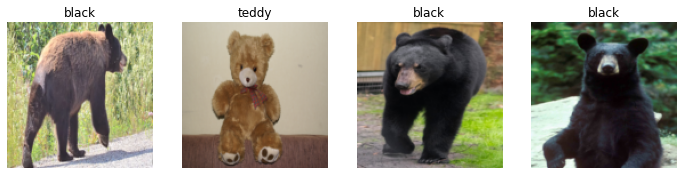

In [10]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dataloaders = bears.dataloaders(path)
dataloaders.valid.show_batch(max_n=4, nrows=1)

### Padding

By padding, the image is surrounded typically by black, meaningless pixels.
This results in extra, wasted computation.

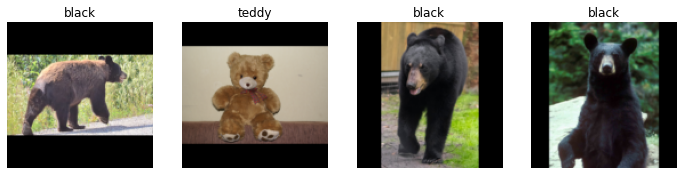

In [11]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dataloaders = bears.dataloaders(path)
dataloaders.valid.show_batch(max_n=4, nrows=1)

The best approach is to take random crops of different parts of the same
image. This makes sure that the model does not miss out on any details whilst
 letting it "know" how an object fully looks like.

Below, we have `unique=True` so that the same image is repeated with different variations.

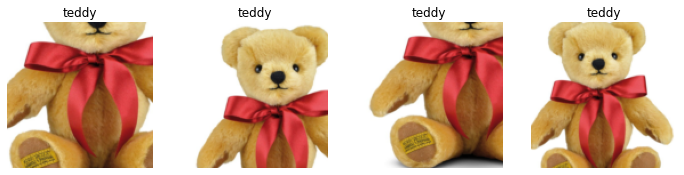

In [12]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dataloaders = bears.dataloaders(path)
dataloaders.train.show_batch(max_n=4, nrows=1, unique=True)

fastai comes with a function that applies a variety of augmentations to
images. This can allow a model to "see" and recognize images in a variety of
scenarios.

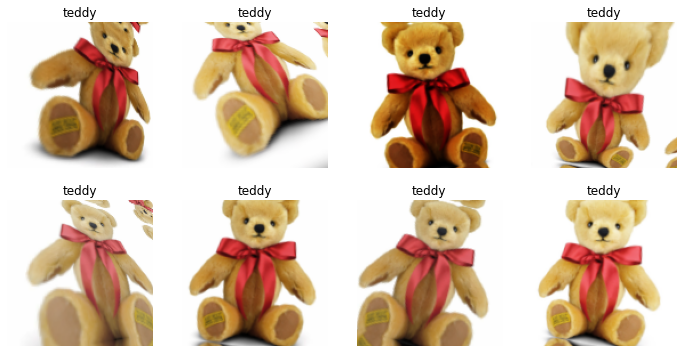

In [13]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dataloaders  = bears.dataloaders(path)
dataloaders.train.show_batch(max_n=8, nrows=2, unique=True)

I have not used `RandomResizedCrop` here so that the different augmentations
can be seen more clearly. `RandomResizedCrop` will be used when the model is
trained.

`batch_tfms` tells fastai that we want to use these transforms on a batch.

## Training the model

We do not have a lot of data. Only 200 images of each bear at most.
Therefore, we will augment our images not only to get more data, but so that
the model can recognize data in a variety of situations.

In [15]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
)
dataloaders = bears.dataloaders(path)

We will now create our learner and fine-tune it.

We will be using the ResNet18 architecture (which is a convolutional neural
network, or CNN for short). Error rate will be the metric.

In [21]:
learn = cnn_learner(dataloaders, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.985666,0.104632,0.025000,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.132230,0.073527,0.012500,00:22
1,0.106222,0.054833,0.018750,00:22
2,0.087129,0.058497,0.012500,00:20
3,0.069890,0.058845,0.018750,00:19


Our model only has a 1.9% error rate! Not bad! Though it seems if I had done
an extra epoch, the error rate may have gone down to 1.3%, judging by the
previous epochs' error rates.

## Visualizing mistakes

We can visualize the mistakes the model is making by a confusion matrix.

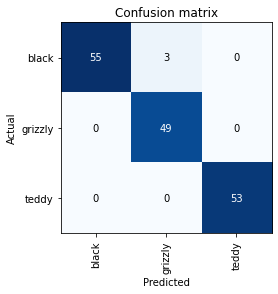

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

3 grizzly bears were misclassified as black bears.

Let us see where the errors are occurring, so we can determine if they are due to a dataset problem or a model problem.

To do this, we will sort images by their loss.

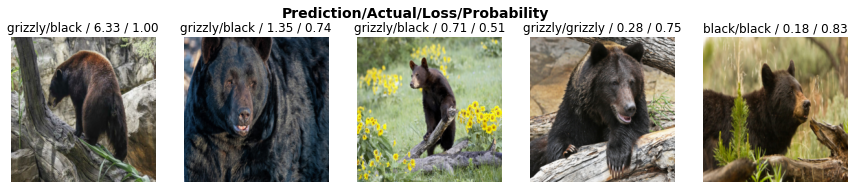

In [23]:
interp.plot_top_losses(5, nrows=1)

## Data cleaning

The intuitive approach to data cleaning is to do it before training the model. However, a trained model can help us clean the data. For example, we can
see some mislabaled bears in the above cases.

fastai includes a GUI for data cleaning. This GUI allows you to choose a
category/label and its associated training and validation sets. It then shows
you images in order of highest-loss first, from which you can select images
for removal or relabeling.

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

`ImageClassifierCleaner` does not actually delete or relabel. It just returns the indices that are to be deleted or relabeled.

In [25]:
# Delete images selected for deletion.
for index in cleaner.delete():
    cleaner.fns[index].unlink()

# Relabel images selected for relabeling.
for index, category in cleaner.change():
    shutil.move(str(cleaner.fns[index]), path/category)

We can now retrain and better performance should be expected.

## Saving the model

A model consists of two parts: the architecture and the parameters.

When we use the `export()` method, both of these are saved.

This method also saves the definition of our `DataLoaders`. This is done so
that we do not have to redefine how to transform our data when the model
is used in production.

fastai uses our validation set `DataLoader` by default, so the data
augmentation will not be applied, which is generally what is wanted.

The `export()` method creates a file named "export.pkl".

In [26]:
learn.export()

Let us check that the file exists.

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

If you wish to deploy an app, this is the file you will need.

## Loading the model for inference

Now obviously we do not need to load the model as we already have the
`learner` variable. But I shall do so anyways.

In [28]:
learn_inf = load_learner(path/'export.pkl')

We generally do inference for a single image at a time.

In [31]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([1.4230e-06, 1.0000e+00, 3.9502e-08]))

Three things have been returned: the predicted category, the index of the predicted category, and the probabilities of each category.

The order of each category is based on the order of the _vocabulary_ of the
`DataLoaders`; that is, the stored tuple of all possible categories.

The `DataLoaders` can be accessed as an attribute of the `Learner`.

In [30]:
learn_inf.dataloaders.vocab

['black', 'grizzly', 'teddy']

## Why CNNs work so well

The ResNet18 architecture is a sort of CNN. Below is my understanding as to
why CNNs work so well.

A neural network is comprised of many layers. Each layer is comprised of many
neurons. In a CNN, each neuron in the same layer is given the exact same
weights, while being given different input data. This allows all neurons in a
 layer to fire upon detecting the same pattern.

Because of this, CNNs can become really good at detecting objects in various
patterns, orientations, shapes, positions, and so on.

## Conclusion

Well then, that wraps up my first deep learning model! I have to say, it is
much easier than I thought it would be to implement a model. You do not need to
 go into the nitty gritty details of artificial intelligence. A high level
 understanding can suffice in the beginning. It is like playing a sport:
you do not need to understand the physics to be able to play it.

If you have any comments, questions, suggestions, feedback, criticisms, or
corrections, please do post them down in the comment section below!